Hoja de trabajo 2 DataScience - Series de tiempo

Andree Toledo
Andres Quinto 18288



In [20]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import StandardScaler
from scipy import stats
import matplotlib.cm as cm
from factor_analyzer import calculate_bartlett_sphericity, calculate_kmo
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline
from apyori import apriori
np.warnings.filterwarnings('ignore', category=np.VisibleDeprecationWarning)
pd.set_option('display.max_rows', None)

Analisis Exploratorio

In [52]:
IMPORT = pd.read_excel('./IMPORTACION-VOLUMEN-2022-05.xlsx', skiprows=6)
CONSUME = pd.read_excel('./CONSUMO-2022-05.xlsx', skiprows=6)
print(IMPORT.columns)
print(CONSUME.columns)

Index(['Unnamed: 0', 'Fecha', 'Gasolina superior', 'Gasolina regular',
       'Total\ngasolinas', 'Diesel alto azufre', 'Diesel bajo azufre',
       'Diesel ultra bajo azufre', 'Diesel', 'Gas licuado de petróleo',
       'Gasolina de aviación', 'Kerosina', 'Combustible turbo jet', 'Bunker',
       'Asfalto ', 'Petcoke', 'Aceites lubricantes', 'Grasas lubricantes',
       'Solventes', 'Naftas', 'Ceras', 'Butano', 'Petróleo reconstituido',
       'MTBE', 'Orimulsión', 'Mezclas oleosas', 'Petróleo crudo',
       'Total importación'],
      dtype='object')
Index(['Unnamed: 0', 'Fecha', 'Gasolina superior', 'Gasolina regular',
       'Total\ngasolinas', 'Diesel alto azufre', 'Diesel bajo azufre',
       'Diesel ultra bajo azufre', 'Diesel', 'Gas licuado de petróleo',
       'Gasolina de aviación', 'Kerosina', 'Turbo jet', 'Bunker', 'Asfalto',
       'PetCoke', 'Aceites lubricantes', 'Grasas lubricantes', 'Solventes',
       'Naftas', 'Ceras', 'Petróleo crudo', 'Butano', 'Orimulsión',
      

Pequeño fix para nombres de la columna

In [53]:
IMPORT.rename(columns={'Gasolina superior': 'Gasolinasuperior','Gasolina regular': 'Gasolinaregular'}, inplace=True)
CONSUME.rename(columns={'Gasolina superior': 'Gasolinasuperior','Gasolina regular': 'Gasolinaregular'}, inplace=True)

Index(['Unnamed: 0', 'Fecha', 'Gasolina superior', 'Gasolina regular',
       'Total\ngasolinas', 'Diesel alto azufre', 'Diesel bajo azufre',
       'Diesel ultra bajo azufre', 'Diesel', 'Gas licuado de petróleo',
       'Gasolina de aviación', 'Kerosina', 'Combustible turbo jet', 'Bunker',
       'Asfalto ', 'Petcoke', 'Aceites lubricantes', 'Grasas lubricantes',
       'Solventes', 'Naftas', 'Ceras', 'Butano', 'Petróleo reconstituido',
       'MTBE', 'Orimulsión', 'Mezclas oleosas', 'Petróleo crudo',
       'Total importación'],
      dtype='object')
Index(['Unnamed: 0', 'Fecha', 'Gasolina superior', 'Gasolina regular',
       'Total\ngasolinas', 'Diesel alto azufre', 'Diesel bajo azufre',
       'Diesel ultra bajo azufre', 'Diesel', 'Gas licuado de petróleo',
       'Gasolina de aviación', 'Kerosina', 'Turbo jet', 'Bunker', 'Asfalto',
       'PetCoke', 'Aceites lubricantes', 'Grasas lubricantes', 'Solventes',
       'Naftas', 'Ceras', 'Petróleo crudo', 'Butano', 'Orimulsión',
      

In [55]:
Relevantes=['Fecha', 'Gasolinasuperior', 'Gasolinaregular', 'Diesel']
SinFecha=['Gasolina superior', 'Gasolina regular', 'Diesel']
consumes = CONSUME[Relevantes]
imports = IMPORT[Relevantes]
# a partir de la linea 270 ya no se toma en relevancia para la interpretacion de datos
consumes = consumes[:270]
imports = imports[:270]

In [56]:
consumes.head(15)

,Fecha,Gasolinasuperior,Gasolinaregular,Diesel
0,2000-01-01 00:00:00,308156.82,202645.2,634667.06
1,2000-02-01 00:00:00,307766.31,205530.96,642380.66
2,2000-03-01 00:00:00,331910.29,229499.56,699807.25
3,2000-04-01 00:00:00,315648.08,210680.4,586803.98
4,2000-05-01 00:00:00,319667.97,208164.34,656948.2
5,2000-06-01 00:00:00,300347.7,195088.74,570919.88
6,2000-07-01 00:00:00,308305.93,204556.77,576436.02
7,2000-08-01 00:00:00,323011.86,218388.51,593770.77
8,2000-09-01 00:00:00,326455.72,213906.96,590145.4
9,2000-10-01 00:00:00,323843.63,213606.65,641113.36


In [57]:
imports.head(15)

,Fecha,Gasolinasuperior,Gasolinaregular,Diesel
0,2001-01-01,373963.96,177776.5,566101.99
1,2001-02-01,243091.07,123115.99,489525.8
2,2001-03-01,312084.38,161726.42,575559.68
3,2001-04-01,285054.89,127338.74,437745.42
4,2001-05-01,300913.67,168730.19,552609.13
5,2001-06-01,333217.19,152899.09,497855.26
6,2001-07-01,195071.86,136299.13,302350.02
7,2001-08-01,268153.26,139365.07,464159.13
8,2001-09-01,308439.07,233643.75,321952.94
9,2001-10-01,305102.28,141550.22,438989.55


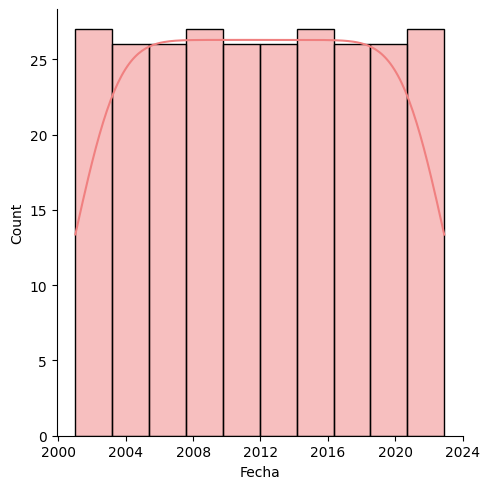

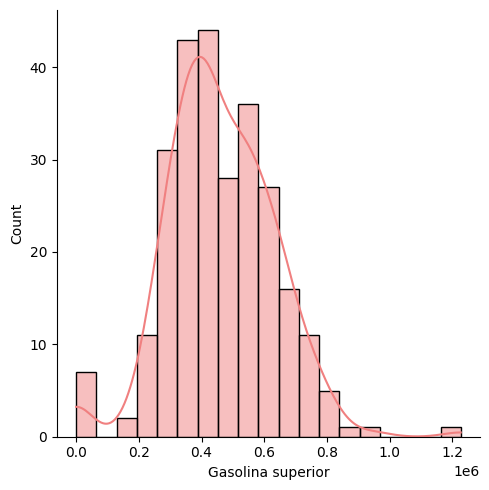

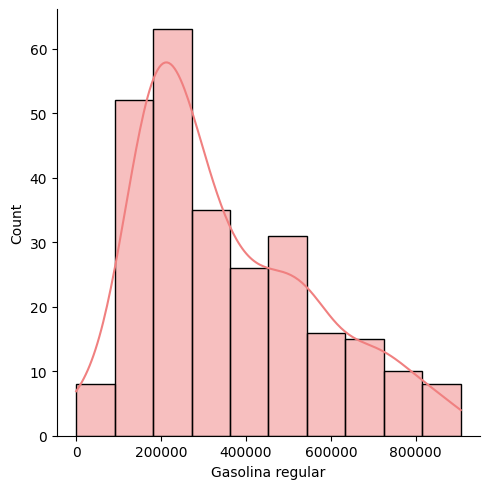

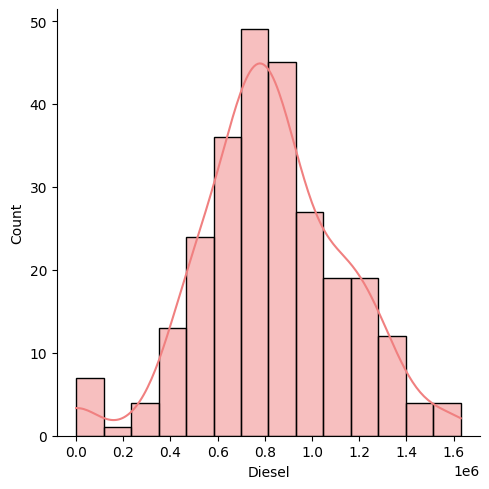

In [25]:
for var in Relevantes:
    sns.displot(imports[var], kde=True, color = 'lightcoral')

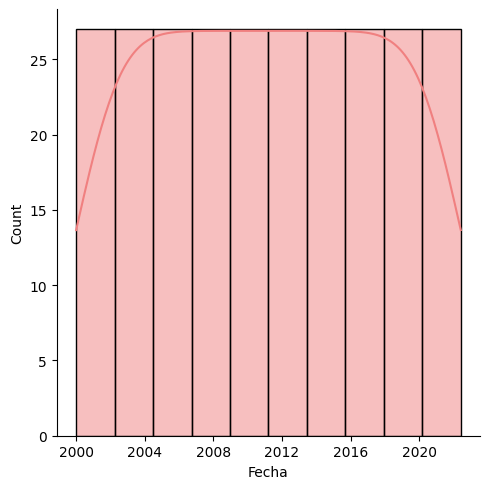

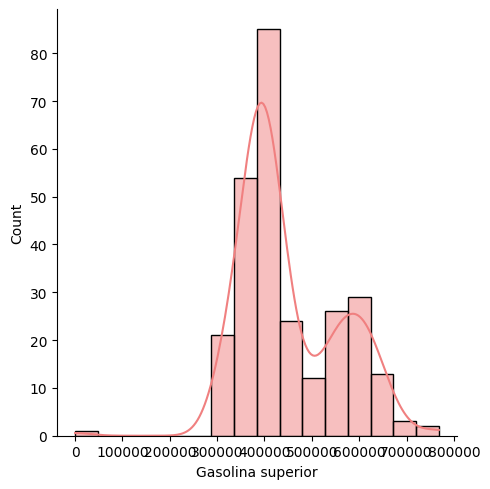

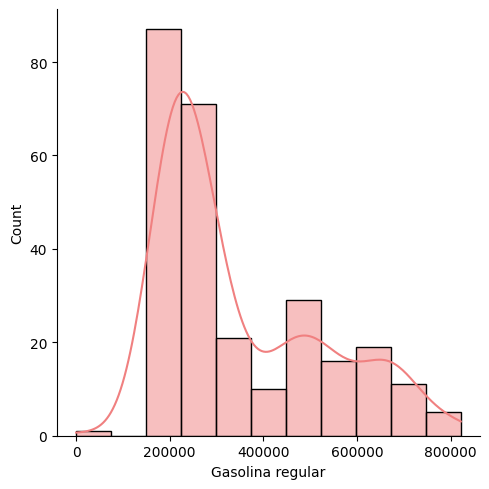

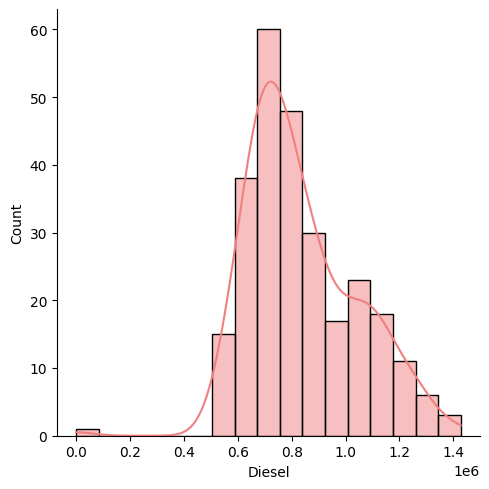

In [26]:
for var in Relevantes:
    sns.displot(consumes[var], kde=True, color='lightcoral')